In [256]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
import folium
from folium.plugins import HeatMap

In [107]:
# Load dataset
df = pd.read_csv('complete_data_new_format.csv', dtype={
    "Province/State": "object",
    "Country/Region": "object",
    "Lat": "float64",
    "Long": "float64",
    "Date": "object",
    "Confirmed": "int64",
    "Deaths": "int64",
})

df.columns = list(df.columns.str.lower())
df.date = df.date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

df.head()

,province/state,country/region,lat,long,date,confirmed,deaths
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0


### How many cases are confirmed over time?

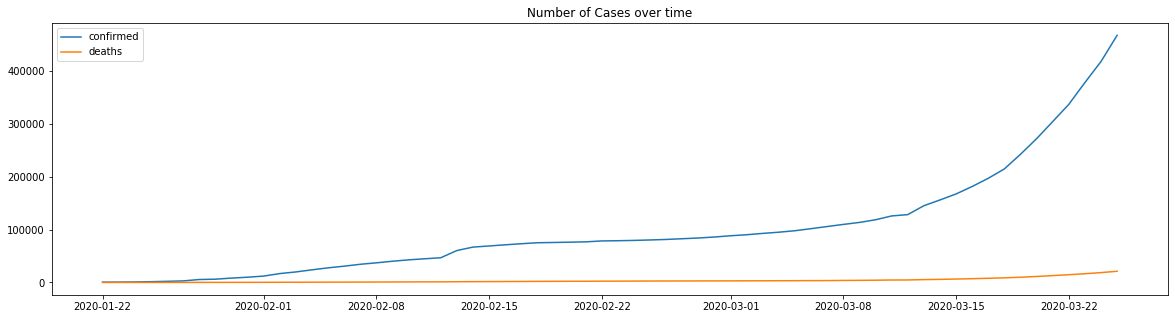

In [108]:
# Aggregate data
temp = df.groupby(["date"]).sum()[["confirmed","deaths"]].reset_index()

# Plot
plt.figure(figsize=[20,5]);
plt.plot(temp.date, temp.confirmed);
plt.plot(temp.date, temp.deaths);
plt.legend(["confirmed","deaths"]);
plt.title("Number of Cases over time");

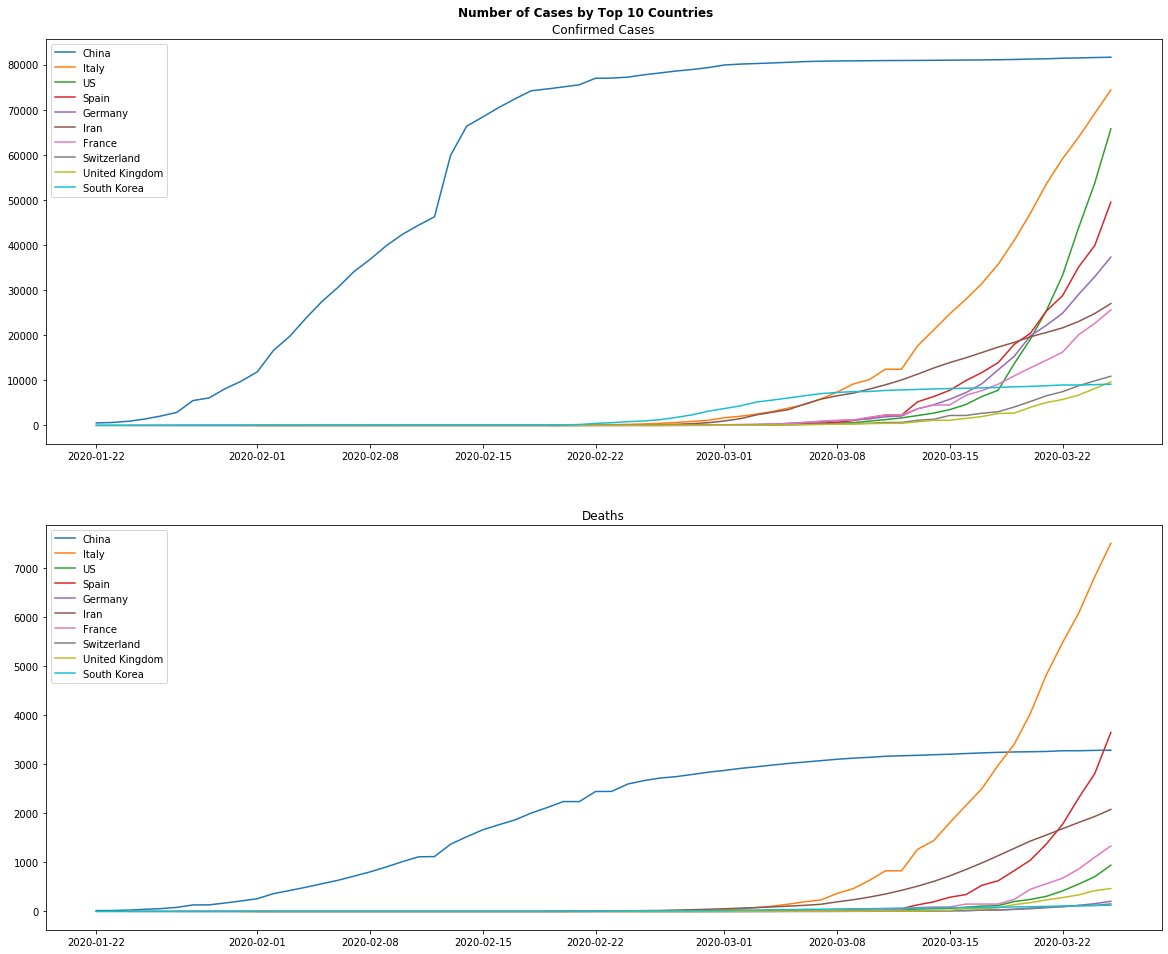

In [127]:
# Get top 10 countries with most cases
temp = df[df.date == df.date.max()]
temp = temp.groupby(["country/region"]).sum()[["confirmed"]].sort_values(by="confirmed", ascending=False)[:10]
countries = list(temp.index)

# Filter table to top 10 countries
temp = df.set_index("country/region").loc[countries]
temp = temp.groupby(["country/region","date"]).sum().reset_index().set_index("country/region")
temp = temp[temp.confirmed > 0]

# Plot
fig = plt.figure(figsize=[20,15]);
fig.suptitle("Number of Cases by Top 10 Countries", fontweight="bold");

plt.subplot(2,1,1);
plt.title("Confirmed Cases");
for c in countries:
    p = temp.loc[c]
    plt.plot(p.date, p.confirmed);
plt.legend(countries);

plt.subplot(2,1,2);
plt.title("Deaths");
for c in countries:
    p = temp.loc[c]
    plt.plot(p.date, p.deaths);
plt.legend(countries);
plt.subplots_adjust(top=.95);

China had the highest number of confirmed cases (>80,000) until 3/25/2020. Based on the exponential curves with Italy, US, Spain (pretty much every country except South Korea), everywhere else in the world is still growing in the number of confirmed cases.

Italy and Spain quickly surpassed China in the number of deaths.

### What are the number of cases by country?

In [116]:
temp = df[df.date == df.date.max()]
print("{} confirmed cases".format(temp.sum()["confirmed"]))
print("{} deaths".format(temp.sum()["deaths"]))

467593 confirmed cases
21180 deaths


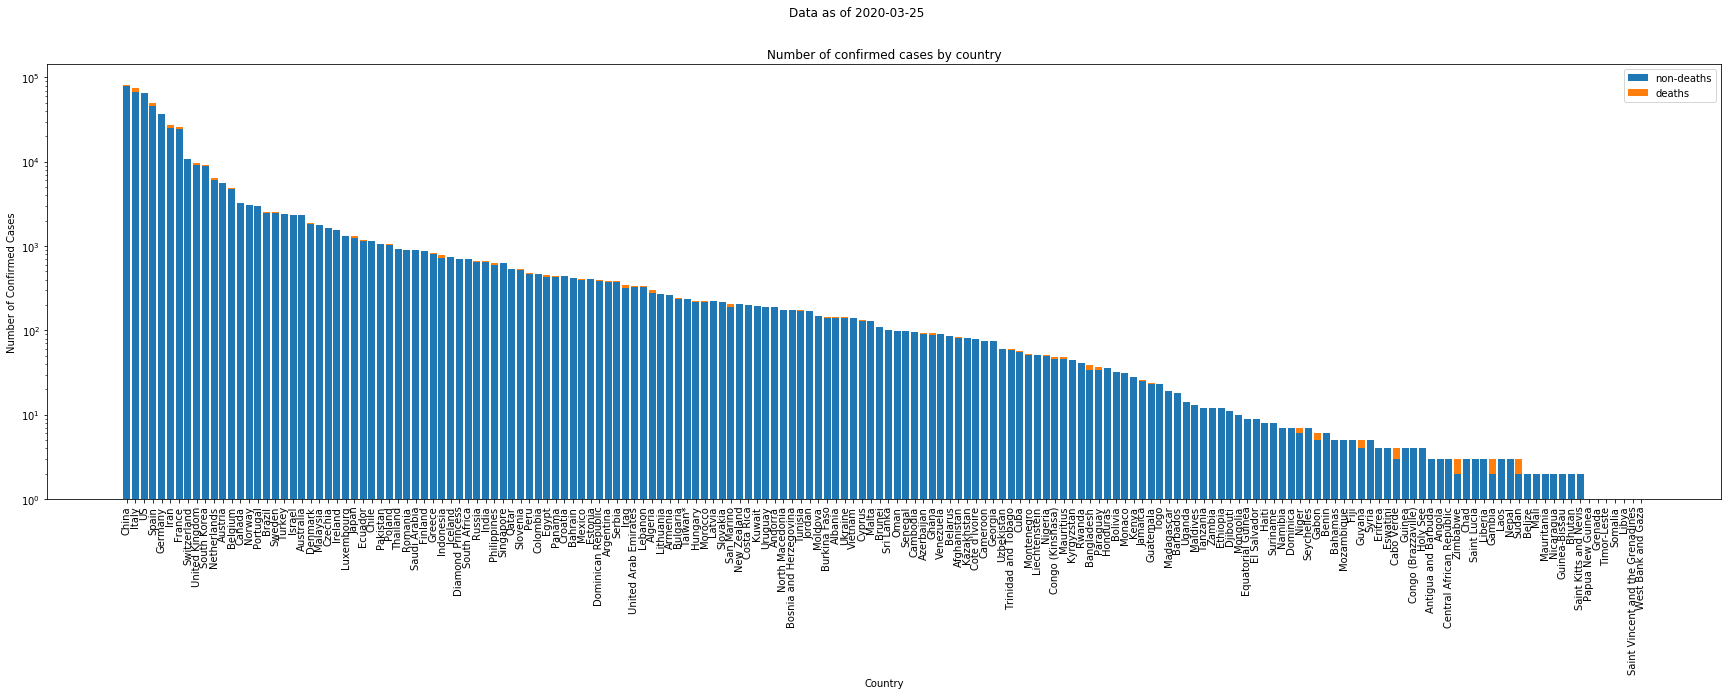

In [121]:
# Get latest date in dataframe
temp = df[df.date == df.date.max()]
temp = temp.groupby("country/region").sum()[["confirmed","deaths"]]

# Create lists as data prep
countries_asc = list(temp.sort_values(by=["confirmed"], ascending=False).index)
temp["non-deaths"] = temp.confirmed - temp.deaths
categories = ["non-deaths","deaths"]
baselines = np.zeros(len(countries_asc))

# Plot stacked bar chart
plt.figure(figsize=[30,8]);
for i in range(len(categories)):
    category = categories[i]
    p = temp[[str(category)]]
    plt.bar(x = np.arange(len(countries_asc)), 
            height = p.loc[countries_asc][str(category)].values, 
            bottom = baselines);
    baselines += p.loc[countries_asc][str(category)].values
plt.xticks(np.arange(len(countries_asc)), countries_asc, rotation="vertical");
plt.legend(categories);
plt.yscale("log");
plt.xlabel("Country");
plt.ylabel("Number of Confirmed Cases");
plt.title("Number of confirmed cases by country");
plt.suptitle("Data as of " + str(df.date.max().date()));

We don't have good data on the number of recovered cases, but so far, the percentage of deaths is low (but still, deaths are significant). Towards the right of the curve, where there are fewer confirmed cases, there are higher death percentages mostly among developing countries.

### What is the growth rate by country?

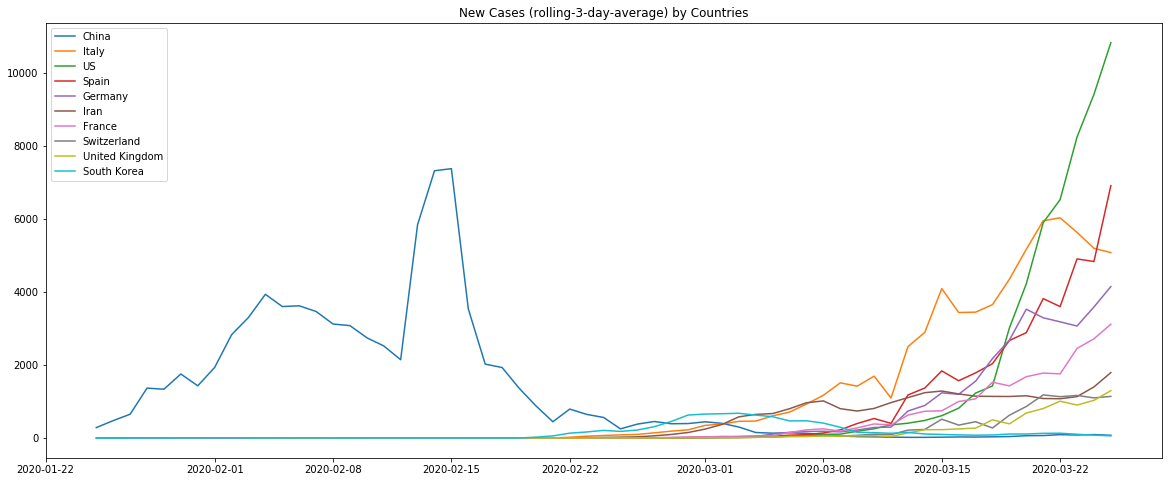

In [111]:
# Get top 10 countries with most cases
temp = df[df.date == df.date.max()]
temp = temp.groupby(["country/region"]).sum()[["confirmed"]].sort_values(by="confirmed", ascending=False)[:10]
countries = list(temp.index)

# Aggregate data and filter to top 10 countries
temp = df.groupby(["country/region","date"]).sum().loc[countries].reset_index()

# Calculate growth rate
def growth_rate(final, start, date):
    """
    Calculate growth rate of cases
    Parameters:
        final: current number of cases
        start: previous number of cases
        date: current date
    """
    if date == datetime(2020,1,22): # avoid shifts from other country/region
        return np.nan
    elif start > 0: # avoid inf
        return final - start
    else:
        return np.nan

temp["lag_confirmed"] = temp.confirmed.transform(lambda x: x.shift())
temp["daily_new_cases"] = temp.apply(lambda x: growth_rate(x.confirmed, x.lag_confirmed, x.date), axis=1)
temp["new_cases_rolling"] = temp.daily_new_cases.rolling(window=3).mean()

# Plot by country
plt.figure(figsize=[20,8]);
for c in countries:
    p = temp[temp["country/region"]== c]
    plt.plot(p.date, p.new_cases_rolling);
plt.legend(countries);
plt.title("New Cases (rolling-3-day-average) by Countries");

We suck.

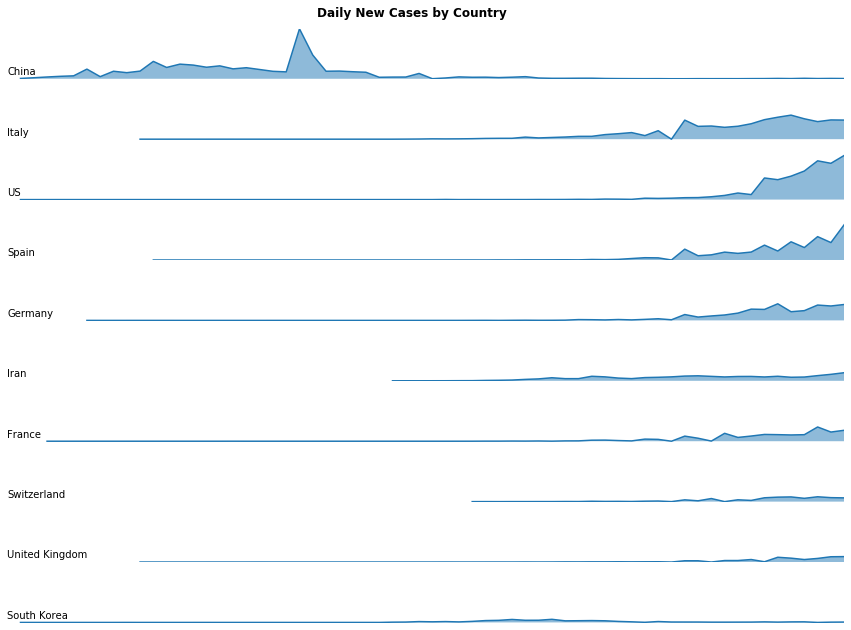

In [112]:
# Get top 10 countries with most cases
temp = df[df.date == df.date.max()]
temp = temp.groupby(["country/region"]).sum()[["confirmed"]].sort_values(by="confirmed", ascending=False)[:10]
countries = list(temp.index)

# Aggregate data and filter to top 10 countries
temp = df.groupby(["country/region","date"]).sum().loc[countries].reset_index()

# Calculate growth rate
def growth_rate(final, start, date):
    """
    Calculate growth rate of cases
    Parameters:
        final: current number of cases
        start: previous number of cases
        date: current date
    """
    if date == datetime(2020,1,22): # avoid shifts from other country/region
        return np.nan
    elif start > 0: # avoid inf
        return final - start
    else:
        return np.nan

temp["lag_confirmed"] = temp.confirmed.transform(lambda x: x.shift())
temp["daily_new_cases"] = temp.apply(lambda x: growth_rate(x.confirmed, x.lag_confirmed, x.date), axis=1)
temp["new_cases_rolling"] = temp.daily_new_cases.rolling(window=1).mean()

# Plot by country
fig = plt.figure(figsize=[15,10]);
fig.suptitle("Daily New Cases by Country", fontweight="bold");
for i in np.arange(len(countries)):
    c = countries[i]
    ax = plt.subplot(len(countries),1,i+1);
    p = temp[temp["country/region"]== c]
    plt.plot(p.date, p.new_cases_rolling);
    plt.fill_between(p.date, p.new_cases_rolling, np.zeros(len(p.date)), alpha=.5);
    plt.text(p.date.min(),1000, c);
    plt.xlabel(None);
    plt.xticks([]);
    plt.yticks([]);
    plt.xlim([temp.date.min(),temp.date.max()]);
    plt.ylim([-100,temp.new_cases_rolling.max()]);
    plt.axis("off");
plt.subplots_adjust(top=.95);


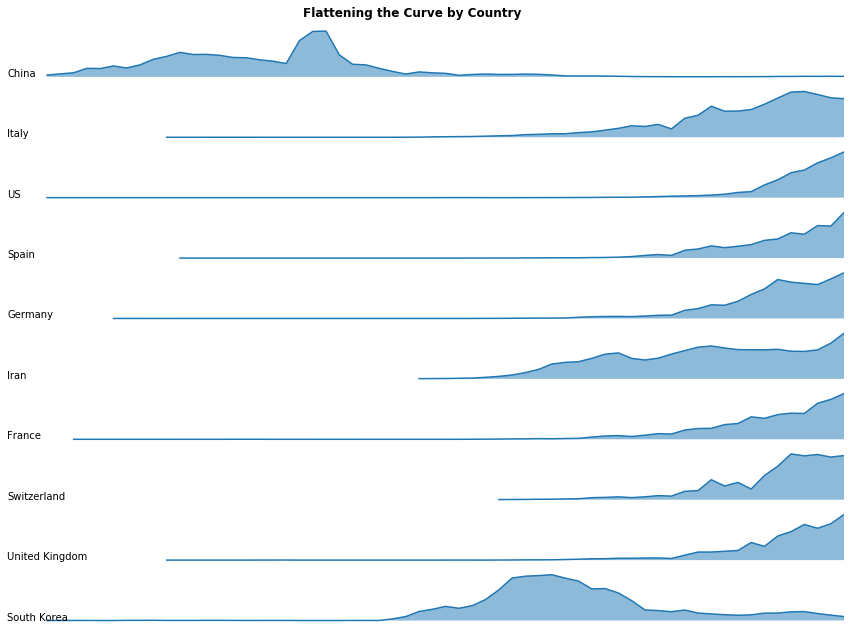

In [113]:
# Get top 10 countries with most cases
temp = df[df.date == df.date.max()]
temp = temp.groupby(["country/region"]).sum()[["confirmed"]].sort_values(by="confirmed", ascending=False)[:10]
countries = list(temp.index)

# Aggregate data and filter to top 10 countries
temp = df.groupby(["country/region","date"]).sum().loc[countries].reset_index()

# Calculate growth rate
def growth_rate(final, start, date):
    """
    Calculate growth rate of cases
    Parameters:
        final: current number of cases
        start: previous number of cases
        date: current date
    """
    if date == datetime(2020,1,22): # avoid shifts from other country/region
        return np.nan
    elif start > 0: # avoid inf
        return final - start
    else:
        return np.nan

temp["lag_confirmed"] = temp.confirmed.transform(lambda x: x.shift())
temp["daily_new_cases"] = temp.apply(lambda x: growth_rate(x.confirmed, x.lag_confirmed, x.date), axis=1)
temp["new_cases_rolling"] = temp.daily_new_cases.rolling(window=3).mean()

# Plot by country
fig = plt.figure(figsize=[15,10]);
fig.suptitle("Flattening the Curve by Country", fontweight="bold");
for i in np.arange(len(countries)):
    c = countries[i]
    ax = plt.subplot(len(countries),1,i+1);
    p = temp[temp["country/region"]== c]
    plt.plot(p.date, p.new_cases_rolling);
    plt.fill_between(p.date, p.new_cases_rolling, np.zeros(len(p.date)), alpha=.5);
    plt.text(p.date.min(),0, c);
    plt.xlim([temp.date.min(),temp.date.max()]);
#     plt.ylim([-100,temp.new_cases_rolling.max()]);
    plt.axis("off");
plt.subplots_adjust(top=.95);


As of 3/25/2020, China and South Korea flattened the rate of their spread (AKA "flattened the curve"). They had earlier onsets, and we'll see how the other countries play out. Although Italy makes a lot of media on the number of patients exceeding the country's capacity of resources, their curve looks like its number of cases are no longer growing exponentially. For both the US and UK, the number of cases will continue to grow. However, the US did not have enough COVID-19 tests until recent, and the discovery of these cases daily might not be indicative of when people were infected. 

### How long did it take?

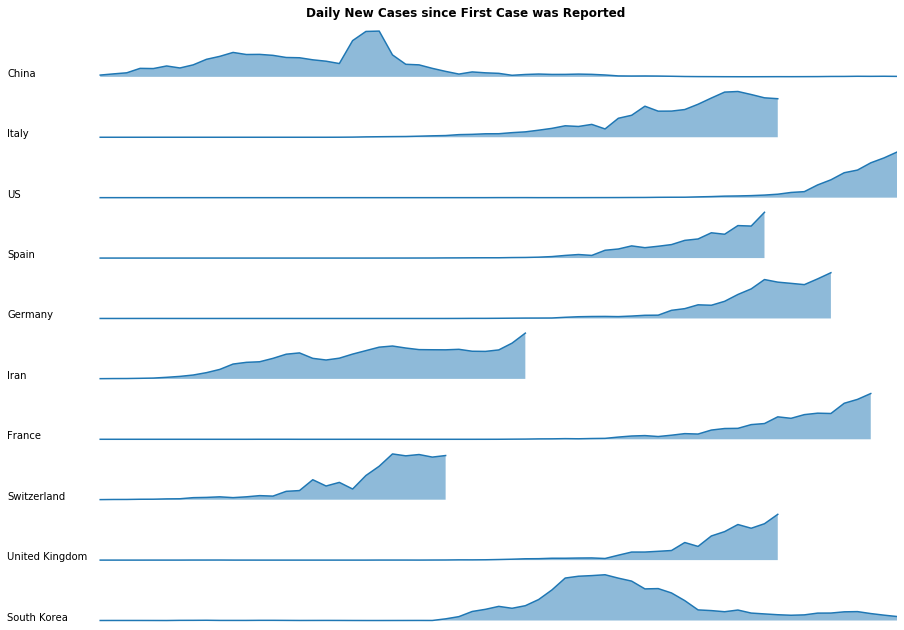

In [182]:
# Get top 10 countries with most cases
temp = df[df.date == df.date.max()]
temp = temp.groupby(["country/region"]).sum()[["confirmed"]].sort_values(by="confirmed", ascending=False)[:10]
countries = list(temp.index)

# Aggregate data and filter to top 10 countries
temp = df.groupby(["country/region","date"]).sum().loc[countries].reset_index()
temp = temp[temp.confirmed > 0]

# Calculate days from first case 
temp["day_of_first_case"] = temp.groupby("country/region").date.transform(np.min)
temp["days_since_first_case"] = temp.apply(lambda x: (x.date - x.day_of_first_case).days, axis=1)

# Calculate growth rate
def growth_rate(final, start, days_since_first_case):
    """
    Calculate growth rate of cases
    Parameters:
        final: current number of cases
        start: previous number of cases
        days_since_first_case: number of days since first case
    """
    if days_since_first_case == 0: # avoid shifts from other country/region
        return np.nan
    elif start > 0: # avoid inf
        return final - start
    else:
        return np.nan

temp["lag_confirmed"] = temp.confirmed.transform(lambda x: x.shift())
temp["daily_new_cases"] = temp.apply(lambda x: growth_rate(x.confirmed, x.lag_confirmed, x.days_since_first_case), axis=1)
temp["new_cases_rolling"] = temp.daily_new_cases.rolling(window=3).mean()

# Plot by country
fig = plt.figure(figsize=[15,10]);
fig.suptitle("Daily New Cases since First Case was Reported", fontweight="bold");
for i in np.arange(len(countries)):
    c = countries[i]
    ax = plt.subplot(len(countries),1,i+1);
    p = temp[temp["country/region"]== c]
    plt.plot(p.days_since_first_case, p.new_cases_rolling);
    plt.fill_between(np.arange(p.shape[0]), p.new_cases_rolling, np.zeros(len(p.date)), alpha=.5);
    plt.text(-4,0, c);
    plt.xlim([0, (df.date.max() - df.date.min()).days]);
#     plt.ylim([-100,temp.new_cases_rolling.max()]);
    plt.axis("off");
plt.subplots_adjust(top=.95);

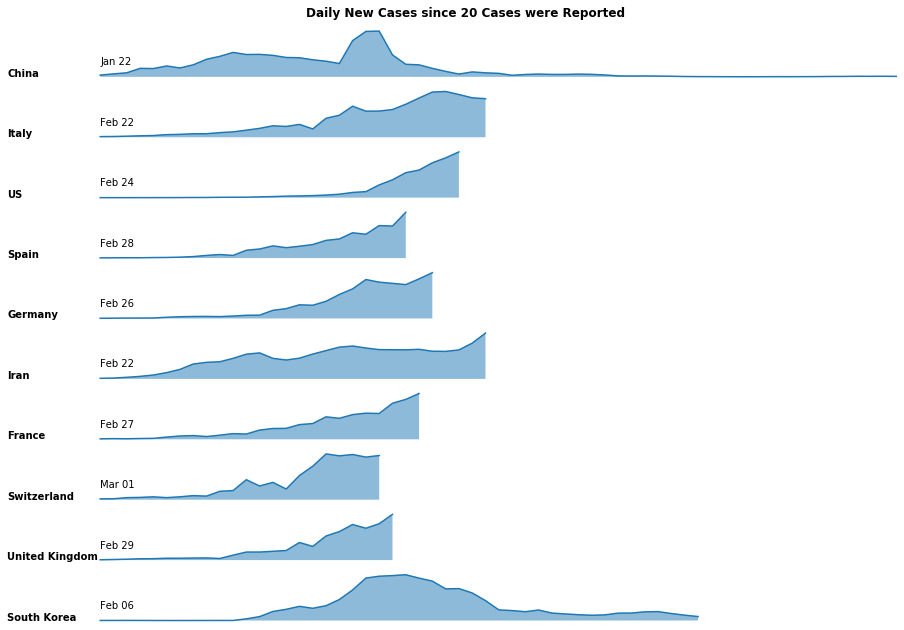

In [204]:
# Get top 10 countries with most cases
temp = df[df.date == df.date.max()]
temp = temp.groupby(["country/region"]).sum()[["confirmed"]].sort_values(by="confirmed", ascending=False)[:10]
countries = list(temp.index)

# Aggregate data and filter to top 10 countries
temp = df.groupby(["country/region","date"]).sum().loc[countries].reset_index()
temp = temp[temp.confirmed > 20]

# Calculate days from first case 
temp["day_of_first_case"] = temp.groupby("country/region").date.transform(np.min)
temp["days_since_first_case"] = temp.apply(lambda x: (x.date - x.day_of_first_case).days, axis=1)

# Calculate growth rate
def growth_rate(final, start, days_since_first_case):
    """
    Calculate growth rate of cases
    Parameters:
        final: current number of cases
        start: previous number of cases
        days_since_first_case: number of days since first case
    """
    if days_since_first_case == 0: # avoid shifts from other country/region
        return np.nan
    elif start > 0: # avoid inf
        return final - start
    else:
        return np.nan

temp["lag_confirmed"] = temp.confirmed.transform(lambda x: x.shift())
temp["daily_new_cases"] = temp.apply(lambda x: growth_rate(x.confirmed, x.lag_confirmed, x.days_since_first_case), axis=1)
temp["new_cases_rolling"] = temp.daily_new_cases.rolling(window=3).mean()

# Plot by country
fig = plt.figure(figsize=[15,10]);
fig.suptitle("Daily New Cases since 20 Cases were Reported", fontweight="bold");
for i in np.arange(len(countries)):
    c = countries[i]
    ax = plt.subplot(len(countries),1,i+1);
    p = temp[temp["country/region"]== c]
    plt.plot(p.days_since_first_case, p.new_cases_rolling);
    plt.fill_between(np.arange(p.shape[0]), p.new_cases_rolling, np.zeros(len(p.date)), alpha=.5);
    plt.text(-4, 0, c, fontweight="bold");
    plt.text(3, p.new_cases_rolling.max()/4, datetime.strftime(p.date.min(),"%b %d"))
    plt.xlim([0, (df.date.max() - df.date.min()).days]);
#     plt.ylim([-100,temp.new_cases_rolling.max()]);
    plt.axis("off");
plt.subplots_adjust(top=.95);

The x-axis represents **Days since the first day with over 20 cases** (Day 0, Day 1, Day 2, ...). I was expecting the curves to line up across countries, but they didn't (due to how/when cases were reported, how cases spread initially and later on). Since these numbers are cases confirmed and reported, they're not reflective of when patients were actually infected and don't represent the entire population of infected people. I was expecting

### What is the spread of cases throughout China?

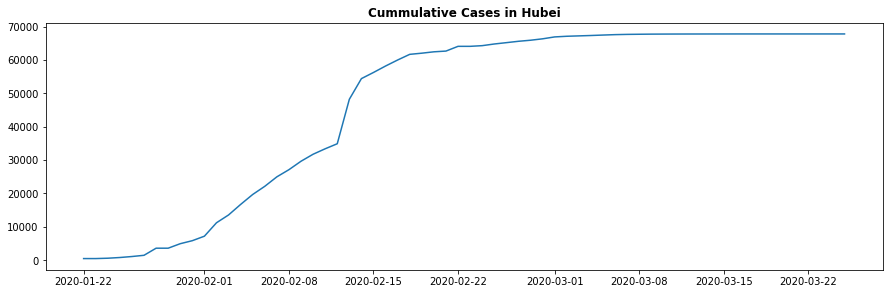

In [228]:
# Plot Cases in Hubei
fig = plt.figure(figsize=[15,10]);
plt.subplot(2,1,1);
plt.title("Cummulative Cases in Hubei", fontweight="bold");
p = df[df["province/state"] == "Hubei"]
plt.plot(p.date, p.confirmed);

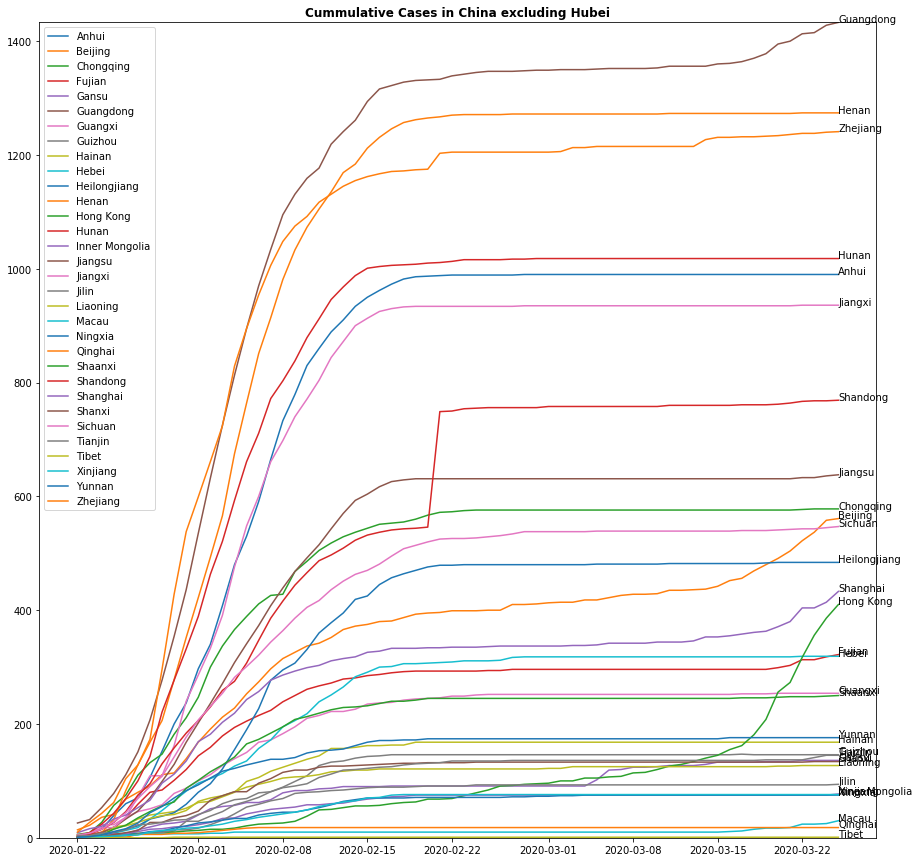

In [229]:
# Plot Cases in rest of China
temp = df[(df["country/region"] == "China") & (df["province/state"] != "Hubei")]
provinces = list(temp["province/state"].unique())

fig = plt.figure(figsize=[15,15]);
plt.title("Cummulative Cases in China excluding Hubei", fontweight="bold");
for i in np.arange(len(provinces)):
    c = provinces[i]
    p = temp[temp["province/state"]== c]
    plt.plot(p.date, p.confirmed);
    plt.ylim([0,temp.confirmed.max()]);
    plt.text(p.date.max(),p.confirmed.max(),c)
plt.legend(provinces);

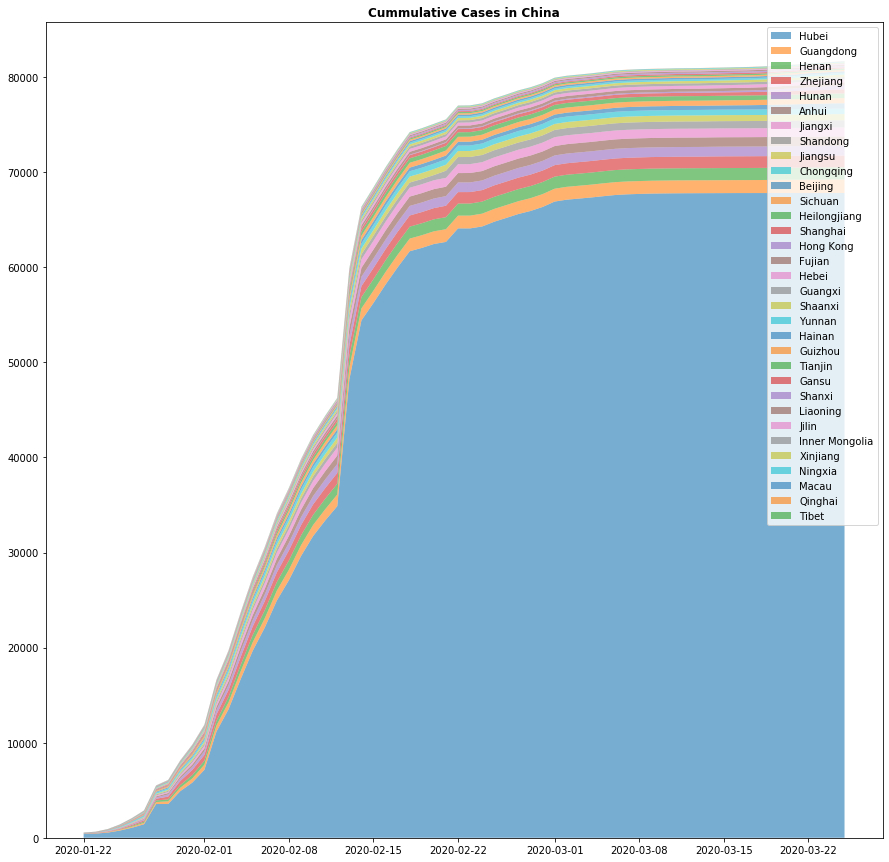

In [243]:
# Plot Total Cases in China
temp = df[df["country/region"] == "China"].sort_values(by="confirmed", ascending=False)
provinces = list(temp["province/state"].unique())
temp = df[df["country/region"] == "China"]

y = []
for province in provinces:
    p = temp[temp["province/state"] == province]
    y.append(p.confirmed)
fig = plt.figure(figsize=[15,15]);
plt.title("Cummulative Cases in China", fontweight="bold");
plt.stackplot(p.date, y, labels = provinces, alpha=.6, linewidth=2);
plt.legend(provinces);

It took roughly 3 weeks to stop the spread (reported new cases) for all provinces excluding Hubei, which had a late respond (being the first epicenter). Hubei might have taken 4 weeks based on the data, but the province had a severe volume of cases.

### Where did the virus spread and how badly?

In [307]:
temp = df[df.date == df.date.max()]

# View on Heat Map
m = folium.Map([20,15], zoom_start=2)
HeatMap(temp[["lat","long","confirmed"]], radius=10, gradient ={.2:"blue",.4:"green",.6:"yellow",.8:"orange",1:"red"}).add_to(m)
display(m)

China, Europe, and US are badly affected.